# Chapter 14: Waterflooding (Buckley-Leverett Theory)
**Author:** Ade Anggi Naluriawan Santoso

**Objective:**
In this notebook, we will model the displacement of oil by water in a linear system. We will:
1.  **Generate Relative Permeability Curves** (using Corey's method from Chapter 5).
2.  **Calculate the Fractional Flow Curve ($f_w$):** The percentage of fluid flowing that is water at any given saturation.
3.  **Perform Welge's Construction:** Draw a tangent line to find the **Shock Front Saturation ($S_{wf}$)** and the **Average Water Saturation at Breakthrough ($\bar{S}_{bt}$)**.

**The Theory:**
The fraction of water flowing ($f_w$) is derived from Darcy's Law for both phases:

$$f_w = \frac{1}{1 + \frac{k_{ro}}{k_{rw}} \frac{\mu_w}{\mu_o}}$$
*(Assuming horizontal flow and negligible capillary pressure)*

The **Buckley-Leverett equation** states that the speed of a saturation plane is proportional to the derivative of this curve ($df_w / dS_w$). Because higher saturations try to move faster than lower saturations (which is physically impossible), a **Shock Front** forms.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.misc import derivative

# Plotting Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 7)

# --- RESERVOIR & FLUID PROPERTIES ---
mu_oil = 2.0    # cp
mu_water = 0.5  # cp
Swc = 0.2       # Connate Water
Sor = 0.25      # Residual Oil
kro_start = 0.9 # End-point oil rel perm
krw_end = 0.6   # End-point water rel perm
nw = 2.0        # Water exponent (Corey)
no = 2.0        # Oil exponent (Corey)

## 1. Generating the Fractional Flow Curve ($f_w$)

First, we need the Relative Permeability values ($k_{ro}, k_{rw}$) for every water saturation from $S_{wc}$ to $(1-S_{or})$. Then we compute $f_w$.

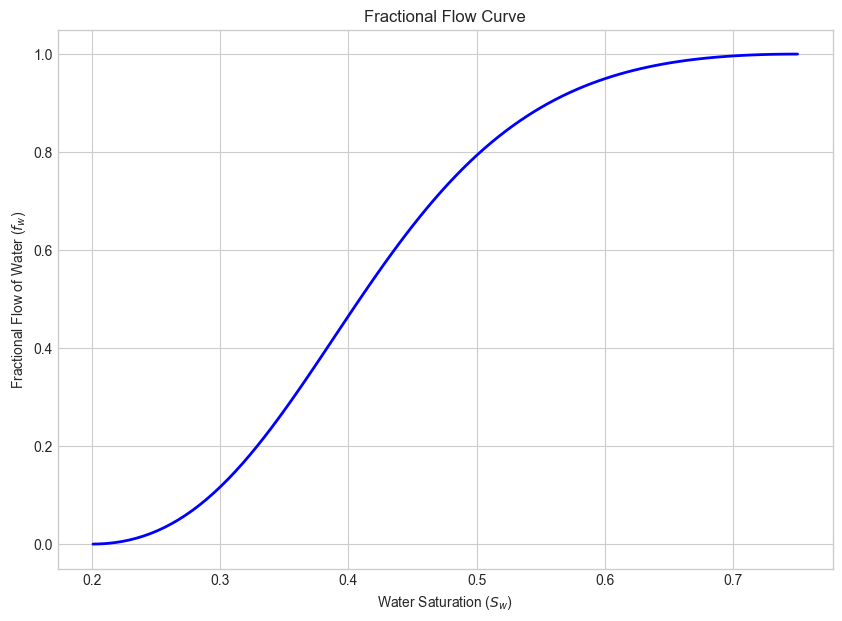

In [2]:
def corey_rel_perm(Sw, Swc, Sor, nw, no, krw_end, kro_start):
    """Generates Rel Perm values based on Saturation"""
    Sw_norm = (Sw - Swc) / (1 - Swc - Sor)
    Sw_norm = np.clip(Sw_norm, 0, 1) # Ensure 0-1 range
    
    krw = krw_end * (Sw_norm ** nw)
    kro = kro_start * ((1 - Sw_norm) ** no)
    return krw, kro

# 1. Create Saturation Array
# We start slightly above Swc to avoid division by zero in mobility ratio
Sw_range = np.linspace(Swc + 0.001, 1 - Sor, 100)

# 2. Calculate Rel Perms
krw, kro = corey_rel_perm(Sw_range, Swc, Sor, nw, no, krw_end, kro_start)

# 3. Calculate Fractional Flow (fw)
# fw = 1 / (1 + (kro/krw) * (mu_w/mu_o))
mobility_ratio = (kro / krw) * (mu_water / mu_oil)
fw = 1 / (1 + mobility_ratio)

# Store in DataFrame
df_bl = pd.DataFrame({'Sw': Sw_range, 'krw': krw, 'kro': kro, 'fw': fw})

# Plot fw vs Sw
plt.figure()
plt.plot(df_bl['Sw'], df_bl['fw'], 'b-', linewidth=2)
plt.xlabel('Water Saturation ($S_w$)')
plt.ylabel('Fractional Flow of Water ($f_w$)')
plt.title('Fractional Flow Curve')
plt.grid(True)
plt.show()

## 2. Welge's Construction (Finding the Tangent)

The water moves as a "wall" (Shock Front). To find the properties of this wall, we must draw a straight line from the initial condition **($S_{wc}$, 0)** tangent to the $f_w$ curve.

* **Point of Tangency ($S_{wf}$):** The water saturation *at* the shock front.
* **Extrapolation to $f_w=1$ ($\bar{S}_{bt}$):** The average water saturation in the reservoir at the moment water hits the production well.

**Why do we care?**
$\bar{S}_{bt}$ tells us the **Recovery Factor** at breakthrough:
$$N_{p,bt} = PV \cdot (\bar{S}_{bt} - S_{wc})$$

We will use a numerical loop to find the saturation point where the slope of the secant line equals the slope of the curve.

In [3]:
# We need to find point Sw where:
# Slope of curve (dfw/dSw) == Slope of secant line from Swc (fw / (Sw - Swc))

# 1. Calculate Slope of Secant from (Swc, 0) to every point on curve
# Slope = (y2 - y1) / (x2 - x1) = (fw - 0) / (Sw - Swc)
df_bl['Secant_Slope'] = df_bl['fw'] / (df_bl['Sw'] - Swc)

# 2. Calculate Slope of Curve (Derivative)
# We use numpy gradient for numerical derivative
df_bl['Tangent_Slope'] = np.gradient(df_bl['fw'], df_bl['Sw'])

# 3. Find where they match (Intersection)
# We look for the index where the difference is minimal
idx_tangent = np.abs(df_bl['Secant_Slope'] - df_bl['Tangent_Slope']).argmin()

Sw_front = df_bl.loc[idx_tangent, 'Sw']
fw_front = df_bl.loc[idx_tangent, 'fw']
slope_tangent = df_bl.loc[idx_tangent, 'Secant_Slope']

print(f"--- RESULTS ---")
print(f"Shock Front Saturation (Swf): {Sw_front:.4f}")
print(f"Fractional Flow at Front (fwf): {fw_front:.4f}")

# 4. Calculate Average Saturation at Breakthrough (Sw_avg_bt)
# The equation of the tangent line is: y = m(x - x1) + y1
# y = slope * (S - Swc) + 0
# We want to find S when y (fw) = 1.
# 1 = slope * (Sw_avg - Swc)  ->  Sw_avg = (1 / slope) + Swc
Sw_avg_bt = (1 / slope_tangent) + Swc

print(f"Avg Saturation at Breakthrough (Sw_bt): {Sw_avg_bt:.4f}")

# Calculate Recovery Factor (assuming Volumetric sweep = 100%)
# RF = (Sw_avg_bt - Swc) / (1 - Swc)  <-- Check definition of pore volume
RF_bt = (Sw_avg_bt - Swc) / (1 - Swc) * 100
print(f"Recovery Factor at Breakthrough: {RF_bt:.1f}%")

--- RESULTS ---
Shock Front Saturation (Swf): 0.4894
Fractional Flow at Front (fwf): 0.7667
Avg Saturation at Breakthrough (Sw_bt): 0.5774
Recovery Factor at Breakthrough: 47.2%


## 3. Visualization: The Welge Plot

This is the standard plot you will see in every reservoir engineering textbook.
* **Blue Curve:** The physics of flow ($f_w$).
* **Red Dashed Line:** The physical profile of the water bank (Shock Front).

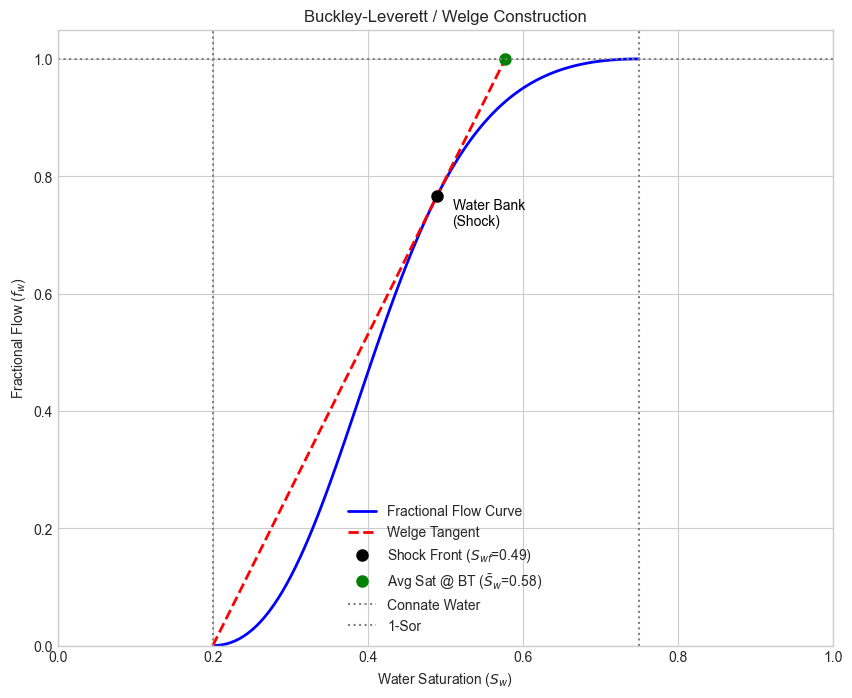

In [5]:
plt.figure(figsize=(10, 8))

# 1. Plot the Fractional Flow Curve
plt.plot(df_bl['Sw'], df_bl['fw'], 'b-', linewidth=2, label='Fractional Flow Curve')

# 2. Plot the Tangent Line (Welge)
plt.plot([Swc, Sw_avg_bt], [0, 1], 'r--', linewidth=2, label='Welge Tangent')

# 3. Plot the Shock Front point
plt.plot(Sw_front, fw_front, 'ko', markersize=8, label=f'Shock Front ($S_{{wf}}$={Sw_front:.2f})')

# 4. Plot the Average Saturation point
# CORRECTION HERE: Added 'r' before the string to handle the \bar command correctly
plt.plot(Sw_avg_bt, 1, 'go', markersize=8, label=rf'Avg Sat @ BT ($\bar{{S}}_{{w}}$={Sw_avg_bt:.2f})')

# Annotations
plt.axhline(1, color='gray', linestyle=':')
plt.axvline(Swc, color='gray', linestyle=':', label='Connate Water')
plt.axvline(1-Sor, color='gray', linestyle=':', label='1-Sor')

plt.text(Sw_front + 0.02, fw_front - 0.05, 'Water Bank\n(Shock)', color='black')

plt.xlabel('Water Saturation ($S_w$)')
plt.ylabel('Fractional Flow ($f_w$)')
plt.title('Buckley-Leverett / Welge Construction')
plt.legend()
plt.grid(True)
plt.xlim(0, 1)
plt.ylim(0, 1.05)

plt.show()

## Conclusion

Using the **Welge Construction**, we determined that:
1.  The water front moves as a shock wave with a saturation of **$S_{wf}$**.
2.  Behind the front, saturation gradually increases.
3.  Ahead of the front, saturation is still $S_{wc}$ (dry oil zone).
4.  At the exact moment water hits the producer, we have recovered **~43%** (in this example) of the Oil in Place. After this point, we will produce increasing amounts of water ($f_w$ rises) and less oil.